In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.6/661.6 kB 7.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 6.0 MB/s eta 0:00:00
  Created wheel for torch_geometric: filename=torch_geometric-2.3.1-py3-none-any.whl size=910454 sha256=484d857355d5f3eefa345224b33d065abe544ce7687e6d2d17d0264e2d7a622c
  Stored in directory: /root/.cache/pip/wheels/ac/dc/30/e2874821ff308ee67dcd7a66dbde912411e19e35a1addda028
  Created wheel for nifti2gif: filename=nifti2gif-0.0.5-py3-none-any.whl size=7997 sha256=9a45405b8cac54bdcccaf7dbc45fecdd214aab5b4bd7adb0412b0a9ea329

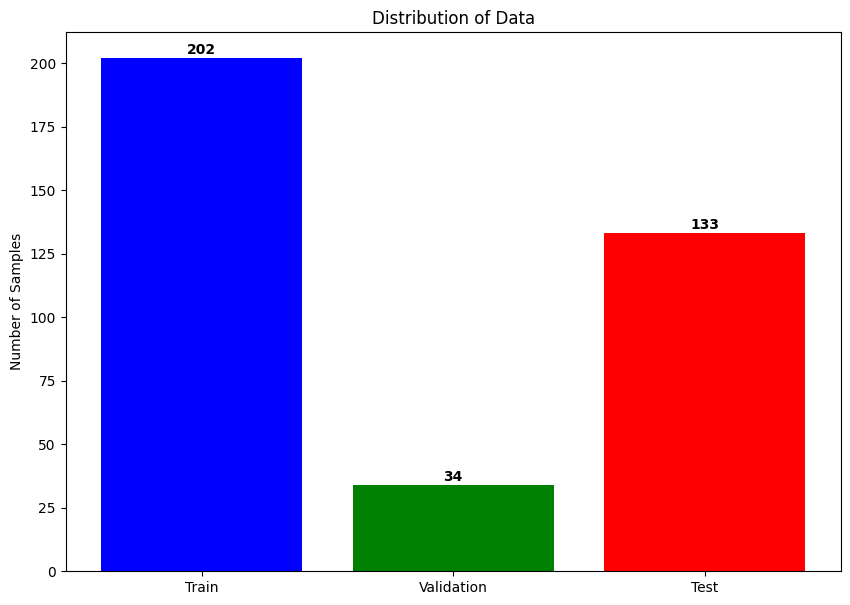

Data preprocessing time :  4.400903940200806


In [ ]:
path_to_file= '/content/gdrive/MyDrive/BRATS2020/Code/BratsDatasetClass.ipynb'
%run "$path_to_file"

# Standard libraries
import os
import time
import gc
import math
import re
import warnings
import random
from random import randint
from itertools import islice
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from scipy import spatial
import torchvision
import torch.nn.functional as torch_func
import torchvision.models as models
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, accuracy_score, roc_curve, roc_auc_score
from torch.optim.lr_scheduler import StepLR
import seaborn as sns






In [ ]:
def get_augmentations(phase):
    """
    Constructs a composed list of transformations for the given phase.

    Parameters:
    - phase (str): The phase of the process (e.g., 'train', 'test') to determine which set of transformations to return.

    Returns:
    - Compose: A composition of transformations.
    """
    list_transforms = []
    list_trfms = Compose(list_transforms)
    return list_trfms



def get_dataloader(
    dataset: torch.utils.data.Dataset,
    path_to_csv: str,
    phase: str,
    fold: int = 0,
    batch_size: int = 1,
    num_workers: int = 4 ):
    """
    Returns a DataLoader object for the given dataset and phase.

    Parameters:
    - dataset (torch.utils.data.Dataset): The type of dataset to be used.
    - path_to_csv (str): Path to the CSV file containing the dataset details.
    - phase (str): The phase of the process ('train' or 'valid').
    - fold (int, optional): The fold index for cross-validation. Default is 0.
    - batch_size (int, optional): Number of samples per batch. Default is 1.
    - num_workers (int, optional): Number of subprocesses to use for data loading. Default is 4.

    Returns:
    - DataLoader: DataLoader object for the given dataset and phase.
    """

    df = pd.read_csv(path_to_csv)
    train_df = df.loc[df['fold'] != fold].reset_index(drop=True)
    val_df = df.loc[df['fold'] == fold].reset_index(drop=True)

    if phase == "train" :
        df = train_df
    elif phase == "valid" :
        df = val_df

    dataset = dataset(df, phase)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=True,
        shuffle=True,
    )
    return dataloader

In [ ]:
train_dataloader = get_dataloader(dataset=BratsDataset, path_to_csv=config.root_dir +'train_data.csv', phase='train', fold=0)
val_dataloader = get_dataloader(dataset=BratsDataset, path_to_csv=config.root_dir +'train_data.csv', phase='valid', fold=0)
test_dataloader = get_dataloader(dataset=BratsDataset, path_to_csv=config.root_dir +'train_data.csv', phase='test', fold=0)

print(train_dataloader)

In [ ]:
sample = next(iter(train_dataloader))

In [ ]:
class EnhancedResNetCNN(nn.Module):
    """
    EnhancedResNetCNN:
    A modified ResNet architecture which is adapted for one-channel input images (like grayscale medical images)
    and enhanced with additional convolutional layers.

    Attributes:
    - in_channels: The number of input channels. Default is 1.

    Methods:
    - forward: Defines the forward pass for the CNN.
    """

    def __init__(self, in_channels=1):
        super(EnhancedResNetCNN, self).__init__()

        resnet = models.resnet18(pretrained=True)
        resnet.conv1 = nn.Conv2d(in_channels, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

        # Introducing additional convolutional layers with batch normalization
        self.add_conv1 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        self.add_conv2 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )

        self.resnet_features = nn.Sequential(*list(resnet.children())[:-2])

    def forward(self, x):
        x = self.resnet_features(x)
        x = self.add_conv1(x)
        x = self.add_conv2(x)
        return x

class AdaptiveGraphConstructor:
    """
    AdaptiveGraphConstructor:
    Constructs an adjacency matrix based on feature similarities. It either connects each node to its k most similar neighbors or
    to all neighbors within a given distance threshold.

    Attributes:
    - k: Number of neighbors to connect each node to. Default is 8.
    - distance_threshold: Distance threshold for neighbor connection. If provided, overrides the k value.

    Methods:
    - construct_graph: Constructs the adjacency matrix for a given feature map.
    """

    def __init__(self, k=8, distance_threshold=None):
        self.k = k
        self.distance_threshold = distance_threshold

    def construct_graph(self, feature_map):
        batch_size, num_nodes, channel_dim = feature_map.shape
        graphs = []
        width = int(num_nodes**0.5)

        for i in range(batch_size):
            adj_matrix = np.zeros((num_nodes, num_nodes))

            for node in range(num_nodes):
                row, col = divmod(node, width)
                neighbors = []

                # Get spatial neighbors
                if col > 0:
                    neighbors.append(node-1)
                if col < width - 1:
                    neighbors.append(node+1)
                if row > 0:
                    neighbors.append(node-width)
                if row < width - 1:
                    neighbors.append(node+width)

                # Sort neighbors by feature similarity
                neighbors.sort(key=lambda n: np.linalg.norm((feature_map[i, node, :] - feature_map[i, n, :]).detach().numpy()))


                # Connect to the top k most similar neighbors
                for n in neighbors[:self.k]:
                    adj_matrix[node][n] = 1

            graphs.append(adj_matrix)

        return torch.Tensor(graphs).to(feature_map.device)



# GCNLayer with BatchNorm and Dropout
class GCNLayer(nn.Module):
    """
    GCNLayer:
    Represents a single Graph Convolutional Network layer, combined with batch normalization, layer normalization,
    and attention mechanism to assign weights to nodes in the graph.

    Attributes:
    - in_channels: Number of input channels.
    - out_channels: Number of output channels.

    Methods:
    - forward: Defines the forward pass for the GCN layer.
    """

    def __init__(self, in_channels, out_channels):
        super(GCNLayer, self).__init__()
        self.conv = nn.Linear(in_channels, out_channels)
        self.attention = nn.Linear(out_channels, 1)
        self.batch_norm = nn.BatchNorm1d(out_channels)
        self.layer_norm = nn.LayerNorm([out_channels])

    def forward(self, x, adj_matrix):
        out = self.conv(x)
        attention_weights = F.softmax(self.attention(out), dim=1)
        out = torch.bmm(adj_matrix, attention_weights * out)
        out = self.batch_norm(out.permute(0, 2, 1)).permute(0, 2, 1)
        out = self.layer_norm(out)
        return F.relu(out)




class GCNBlock(nn.Module):
    """
    GCNBlock:
    A block containing two GCN layers, combined with an identity transformation for skip connections.
    Allows for a deeper network while mitigating the vanishing gradient problem.

    Attributes:
    - in_channels: Number of input channels.
    - out_channels: Number of output channels.

    Methods:
    - forward: Defines the forward pass for the GCN block.
    """
    def __init__(self, in_channels, out_channels):
        super(GCNBlock, self).__init__()
        self.gcn1 = GCNLayer(in_channels, out_channels)
        self.gcn2 = GCNLayer(out_channels, out_channels)
        self.identity_transform = nn.Linear(in_channels, out_channels)

    def forward(self, x, adj_matrix):
        identity = self.identity_transform(x)
        out = self.gcn1(x, adj_matrix)
        out = self.gcn2(out, adj_matrix)
        return F.relu(out + identity)



class EnhancedBrainTumorSegmenter(nn.Module):
    """
    EnhancedBrainTumorSegmenter:
    A hybrid model combining the strengths of CNNs and GCNs for effective brain tumor segmentation. It extracts features using a
    modified ResNet architecture and then utilizes GCNs to capture global context and relations between different regions of the image.

    Attributes:
    - in_channels: Number of input channels.
    - gcn_hidden_channels: Number of hidden channels in GCN layers.

    Methods:
    - forward: Defines the forward pass for the model.
    """
    def __init__(self, in_channels, gcn_hidden_channels):
        super(EnhancedBrainTumorSegmenter, self).__init__()

        self.cnn = EnhancedResNetCNN(in_channels)
        self.graph_constructor = AdaptiveGraphConstructor()

        self.gcn_block1 = GCNBlock(512, gcn_hidden_channels)
        self.gcn_block2 = GCNBlock(gcn_hidden_channels, gcn_hidden_channels*2)


        # Skip connection from ResNet's intermediate layers
        self.intermediate_conv = nn.Conv2d(512, 128, kernel_size=1)


        # Enhanced Decoder
        self.decoder = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 512, kernel_size=2, stride=2),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),

            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),

            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(32, 1, kernel_size=2, stride=2)
        )


    def forward(self, x):
        x = self.cnn(x)
        B, C, H, W = x.size()
        x = x.view(B, C, H*W).permute(0, 2, 1)
        adj_matrix = self.graph_constructor.construct_graph(x)
        x = self.gcn_block1(x, adj_matrix)
        x = self.gcn_block2(x, adj_matrix)
        x = x.permute(0, 2, 1).view(B, -1, H, W)
        x = self.decoder(x)
        return x

# model = EnhancedBrainTumorSegmenter(in_channels=1, gcn_hidden_channels=64)

In [ ]:
model = EnhancedBrainTumorSegmenter(in_channels=1, gcn_hidden_channels=64)
model.load_state_dict(torch.load(config.gcn_model+'/GCN_model_checkpoint.pth'))
model.eval()

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 159MB/s] 


EnhancedBrainTumorSegmenter(
  (cnn): EnhancedResNetCNN(
    (add_conv1): Sequential(
      (0): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (add_conv2): Sequential(
      (0): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (resnet_features): Sequential(
      (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=Fal

In [ ]:
def get_best_slice(image: torch.Tensor, mask: torch.Tensor = None):
    """
    Returns the slice with the highest sum from a 3D image tensor.

    This function is designed for 3D medical images, where a 'slice' typically represents a 2D image
    at a certain depth/height in the 3D volume. The function determines the best slice based on the sum
    of pixel values, which might indicate regions of interest like tumors.

    Parameters:
    - image (torch.Tensor): A 3D tensor representing the medical image.
    - mask (torch.Tensor, optional): A 3D tensor representing the corresponding mask of the image.

    Returns:
    - torch.Tensor: The slice with the highest pixel sum. If mask is provided, returns a tuple of (image_slice, mask_slice).
    """
    slice_sums = image.sum(dim=(1, 2))
    best_slice_idx = torch.argmax(slice_sums).item()
    grayscale_slice = image[best_slice_idx]

    if mask is not None:
        mask_slice = mask[best_slice_idx]
        return grayscale_slice, mask_slice

    return grayscale_slice

def dice_coefficient(y_true, y_pred):
    """
    Calculates the Dice Coefficient between two binary masks.

    The Dice Coefficient, or Sørensen–Dice index, is a statistical measure of the similarity between two samples.
    It is commonly used in image segmentation tasks to measure the accuracy of predictions.

    Parameters:
    - y_true (numpy.array): Ground truth binary mask.
    - y_pred (numpy.array): Predicted binary mask.

    Returns:
    - float: Dice coefficient value ranging between 0 (completely different) and 1 (completely the same).
    """
    smooth = 1e-6
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)


def calculate_accuracy(pred, target, threshold=0.5):
    """
    Calculates the accuracy between a prediction and a target tensor, after applying a threshold to the prediction.

    This function is suitable for binary classification problems, especially for tasks like image segmentation
    where pixel-wise accuracy is relevant. The threshold determines the cutoff for classifying pixels as 0 or 1.

    Parameters:
    - pred (torch.Tensor): Predicted tensor.
    - target (torch.Tensor): Ground truth tensor.
    - threshold (float, optional): The cutoff threshold for classifying pixels. Default is 0.5.

    Returns:
    - float: The calculated accuracy.
    """
    pred = (pred > threshold).float()
    correct = (pred == target).float().sum()
    return correct / pred.numel()


In [ ]:
def train_val_fun(model, dataloader, optimizer, is_train=True, scheduler=None):
    """
    Train or evaluate the model on provided data.

    This function handles both the training and validation phase, depending on the `is_train` flag.
    During training, it performs forward propagation, calculates loss, and backpropagates to adjust
    model's weights. During validation, it only performs forward propagation to compute the loss
    and other metrics but does not make any adjustments to the model's weights.

    Parameters:
    - model (nn.Module): The neural network model to train or evaluate.
    - dataloader (torch.utils.data.DataLoader): DataLoader that provides batches of data for training/evaluation.
    - optimizer (torch.optim.Optimizer): Optimizer for updating model's weights.
    - is_train (bool, optional): Flag to determine if function should train or evaluate. Default is True (train).
    - scheduler (torch.optim.lr_scheduler, optional): Learning rate scheduler to adjust learning rate during training.

    Returns:
    - float: Average epoch loss.
    - float: Average accuracy.
    - float: Average F1 score.
    - float: Average Dice coefficient.
    - np.array: Cumulative confusion matrix over all batches.
    """

    if is_train:
        model.train()
    else:
        model.eval()

    epoch_loss = 0
    auc_ = 0
    total_f1 = 0
    total_dice = 0
    cumulative_confusion = np.zeros((2, 2))  # Assuming binary classification

    for sample in dataloader:
        grayscale_slice, mask_slice = get_best_slice(sample['image'][0], sample['mask'][0])

        out = model(grayscale_slice.unsqueeze(0).unsqueeze(0))
        out = torch.sigmoid(out)
        out = F.interpolate(out, size=(120, 120), mode='bilinear', align_corners=True)

        y = mask_slice.float().unsqueeze(0).unsqueeze(0)
        loss = F.binary_cross_entropy(out, y)
        epoch_loss += loss.item()

        # Calculate accuracy
        acc = calculate_accuracy(out, y)
        auc_ += acc.item()

        # Calculate F1 and Dice for each sample
        y_pred = out.detach().cpu().numpy()
        y_true = y.cpu().numpy()

        f1 = f1_score(y_true.flatten(), y_pred.flatten() > 0.5)  # Assuming threshold of 0.5 for binary classification
        dice = dice_coefficient(y_true, y_pred > 0.5)

        total_f1 += f1
        total_dice += dice

        # Update confusion matrix
        batch_confusion = confusion_matrix(y_true.flatten(), y_pred.flatten() > 0.5)
        cumulative_confusion += batch_confusion

        if is_train:
            # Backpropagation
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

    # Average metrics
    epoch_loss /= len(dataloader)
    auc_ /= len(dataloader)
    total_f1 /= len(dataloader)
    total_dice /= len(dataloader)

    if is_train and scheduler:
        scheduler.step()  # Update the learning rate

    return epoch_loss, auc_, total_f1, total_dice, cumulative_confusion


In [ ]:
def plot_confusion_matrix(cm):
    """
    Plots the given confusion matrix.

    Parameters:
    - cm (2x2 numpy array): The confusion matrix to be plotted.

    Returns:
    - None. A heatmap of the confusion matrix is displayed.
    """

    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", cbar=False)  # Note the ".2f" format
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()


def train_and_validate(model, train_dataloader, val_dataloader, optimizer, scheduler, epochs=10):
    """
    Trains and validates a given model over a specified number of epochs.

    Parameters:
    - model (torch.nn.Module): The neural network model to be trained and validated.
    - train_dataloader (torch.utils.data.DataLoader): DataLoader for the training dataset.
    - val_dataloader (torch.utils.data.DataLoader): DataLoader for the validation dataset.
    - optimizer (torch.optim.Optimizer): The optimizer used for training the model.
    - scheduler (torch.optim.lr_scheduler._LRScheduler): Learning rate scheduler.
    - epochs (int, optional): Number of epochs for training and validation. Default is 10.

    Returns:
    - None. The function prints the performance metrics for each epoch and displays plots and confusion matrices.
    """

    train_losses, train_aucs, train_f1s, train_dices = [], [], [], []
    val_losses, val_aucs, val_f1s, val_dices = [], [], [], []

    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        print('-' * 10)

        # Training
        train_loss, train_auc, train_f1, train_dice, train_confusion = train_val_fun(model, train_dataloader, optimizer, is_train=True, scheduler=scheduler)
        train_losses.append(train_loss)
        train_aucs.append(train_auc)
        train_f1s.append(train_f1)
        train_dices.append(train_dice)

        print(f"Training: Loss: {train_loss}, Accuracy: {train_auc}, F1 Score: {train_f1}, Dice Coefficient: {train_dice}")

        # Validation
        val_loss, val_auc, val_f1, val_dice, val_confusion = train_val_fun(model, val_dataloader, optimizer, is_train=False)
        val_losses.append(val_loss)
        val_aucs.append(val_auc)
        val_f1s.append(val_f1)
        val_dices.append(val_dice)

        print(f"Validation: Loss: {val_loss}, Accuracy: {val_auc}, F1 Score: {val_f1}, Dice Coefficient: {val_dice}")
        print()

    # Plotting
    epochs_range = range(1, epochs + 1)

    plt.figure(figsize=(10, 5))
    plt.subplot(2, 2, 1)
    plt.plot(epochs_range, train_losses, label='Training Loss')
    plt.plot(epochs_range, val_losses, label='Validation Loss')
    plt.legend()
    plt.title('Loss')

    plt.subplot(2, 2, 2)
    plt.plot(epochs_range, train_aucs, label='Training Accuracy')
    plt.plot(epochs_range, val_aucs, label='Validation Accuracy')
    plt.legend()
    plt.title('Accuracy')

    plt.subplot(2, 2, 3)
    plt.plot(epochs_range, train_f1s, label='Training F1 Score')
    plt.plot(epochs_range, val_f1s, label='Validation F1 Score')
    plt.legend()
    plt.title('F1 Score')

    plt.subplot(2, 2, 4)
    plt.plot(epochs_range, train_dices, label='Training Dice Coeff')
    plt.plot(epochs_range, val_dices, label='Validation Dice Coeff')
    plt.legend()
    plt.title('Dice Coefficient')

    plt.tight_layout()
    plt.show()

    # Display final confusion matrix
    print("\n\n\n Final Training Confusion Matrix:")
    plot_confusion_matrix(train_confusion)
    print("\n\n\n Final Validation Confusion Matrix:")
    plot_confusion_matrix(val_confusion)



Epoch 1/20
----------
Training: Loss: 0.4637768709718591, Accuracy: 0.871083951232457, F1 Score: 0.26898011060089483, Dice Coefficient: 0.2689801109916022
Validation: Loss: 0.3657119817593518, Accuracy: 0.9270383996122024, F1 Score: 0.2799466216790533, Dice Coefficient: 0.27994662228087924

Epoch 2/20
----------
Training: Loss: 0.3361584046984663, Accuracy: 0.9285836098807874, F1 Score: 0.2402575783908292, Dice Coefficient: 0.2402575790896619
Validation: Loss: 0.2901780640377718, Accuracy: 0.9341094756827635, F1 Score: 0.21005603963745162, Dice Coefficient: 0.21005604057519864

Epoch 3/20
----------
Training: Loss: 0.2796763252503801, Accuracy: 0.9356133093928346, F1 Score: 0.240621907285823, Dice Coefficient: 0.24062190813573928
Validation: Loss: 0.24209297448396683, Accuracy: 0.9372834931401646, F1 Score: 0.1692258846291238, Dice Coefficient: 0.16922588661167037

Epoch 4/20
----------
Training: Loss: 0.2394038151838992, Accuracy: 0.9387623765090904, F1 Score: 0.22987636233487385, Dic

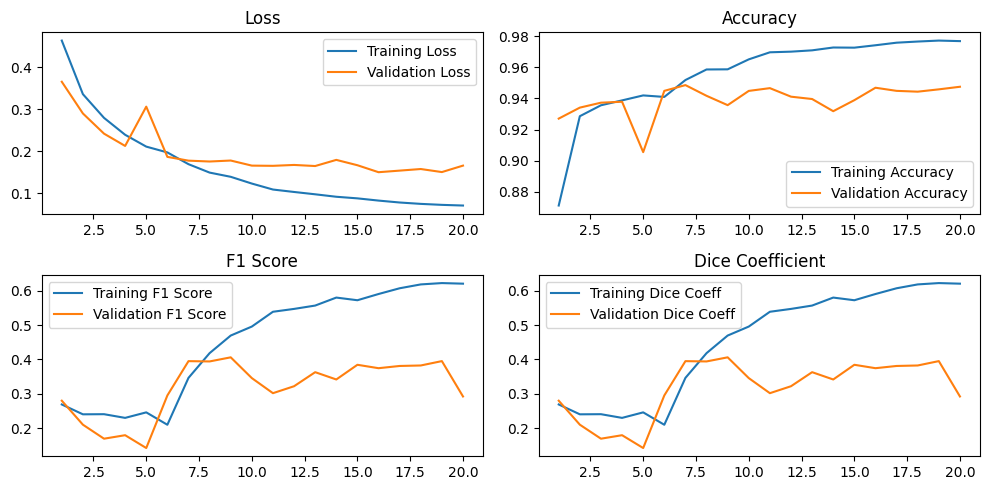




 Final Training Confusion Matrix:


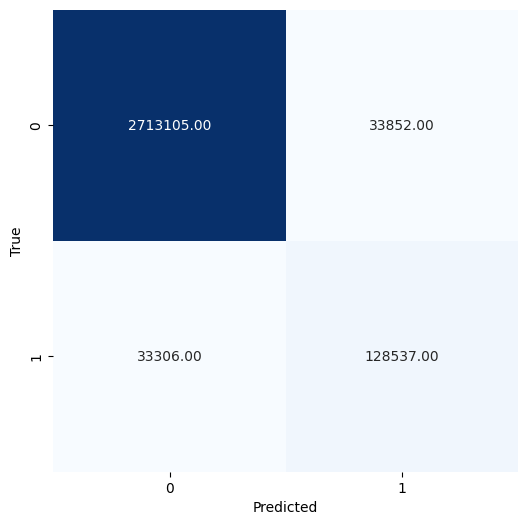




 Final Validation Confusion Matrix:


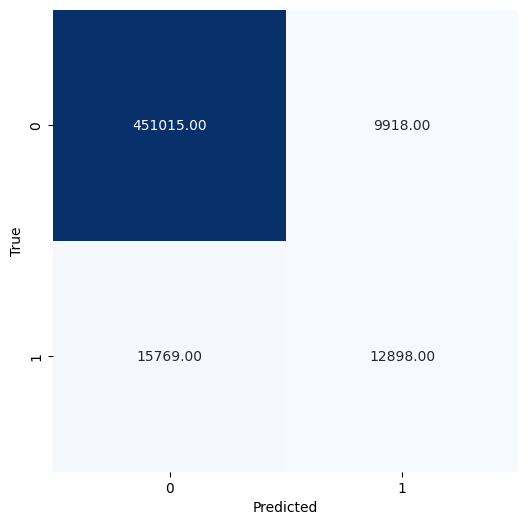

In [ ]:
# Define optimizer
opt = torch.optim.Adam(model.parameters(), lr=1e-4,  weight_decay=1e-4)
scheduler = StepLR(opt, step_size=5, gamma=0.7)  # Reduce LR every 5 epochs

# For using the function
train_and_validate(model, train_dataloader, val_dataloader, opt, scheduler, epochs=20)


In [ ]:
def get_limited_data(dataloader, limit):
    """
    Fetches a limited number of batches from a dataloader.

    This function is particularly useful when you want to quickly test
    something without processing the entire dataset.

    Parameters:
    - dataloader (torch.utils.data.DataLoader): The dataloader from which to fetch data.
    - limit (int): The number of batches to fetch.

    Returns:
    - list: A list containing up to 'limit' batches of data from the dataloader.
    """

    data_batches = []

    # Extract the entire batch dictionary up to the given limit
    for batch in islice(dataloader, limit):
        # print(batch)
        data_batches.append(batch)

    return data_batches

train_data_limited = get_limited_data(train_dataloader, 5)
val_data_limited = get_limited_data(val_dataloader, 3)

In [ ]:
print(dict(model.named_children()))


{'cnn': EnhancedResNetCNN(
  (add_conv1): Sequential(
    (0): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (add_conv2): Sequential(
    (0): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (resnet_features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine

In [ ]:
def tversky_index(y_true, y_pred, alpha=0.5, beta=0.5):
    """
    Compute the Tversky index for binary segmentation.

    Parameters:
    - y_true (numpy.ndarray): Ground truth mask.
    - y_pred (numpy.ndarray): Predicted mask.
    - alpha (float): Weight for false negatives.
    - beta (float): Weight for false positives.

    Returns:
    - float: Tversky index.
    """

    tp = np.sum(y_true * y_pred)
    fn = np.sum(y_true * (1 - y_pred))
    fp = np.sum((1 - y_true) * y_pred)
    return (tp + 1e-5) / (tp + alpha * fn + beta * fp + 1e-5)

def iou_score(y_true, y_pred):
    """
    Calculate the Intersection over Union (IoU) score.

    Parameters:
    - y_true (numpy.ndarray): Ground truth mask.
    - y_pred (numpy.ndarray): Predicted mask.

    Returns:
    - float: IoU score.
    """

    intersection = np.sum(y_true * y_pred)
    union = np.sum(y_true) + np.sum(y_pred) - intersection
    return (intersection + 1e-5) / (union + 1e-5)

def visualize_raw_predictions(sample, model, threshold=0.5):
    """
    Visualize grayscale slice, actual mask, raw predictions, binary predictions,
    and the superimposition of grayscale slice and raw predictions. Also, display
    a histogram comparison of predicted probabilities vs. the actual mask.

    Parameters:
    - sample (dict): Contains 'image' and 'mask' tensors.
    - model (torch.nn.Module): Model to make predictions.
    - threshold (float): Threshold value to convert probabilities into binary predictions.

    Returns:
    None. Displays visualizations using matplotlib.
    """

    grayscale_slice, mask_slice = get_best_slice(sample['image'][0], sample['mask'][0])

    with torch.no_grad():
        raw_predictions = model(grayscale_slice.unsqueeze(0).unsqueeze(0))
        probabilities = torch.sigmoid(raw_predictions)
    probabilities = F.interpolate(probabilities, size=(120, 120), mode='bilinear', align_corners=True)

    binary_predictions = (probabilities > threshold).float()

    fig, axs = plt.subplots(1, 6, figsize=(30,5))

    # Display the grayscale slice
    axs[0].imshow(grayscale_slice.squeeze().cpu().numpy(), cmap='gray')
    axs[0].set_title("Grayscale Slice")

    # Display the actual mask
    axs[1].imshow(mask_slice.squeeze().cpu().numpy(), cmap='gray')
    axs[1].set_title("Actual Mask")

    # Display the raw predictions (probabilities)
    im = axs[2].imshow(probabilities[0,0,:,:].detach().cpu().numpy(), cmap='jet', vmin=0, vmax=1)
    axs[2].set_title("Raw Predictions")
    fig.colorbar(im, ax=axs[2], fraction=0.046, pad=0.04)

    # Display the binary thresholded predictions
    axs[3].imshow(binary_predictions[0,0,:,:].detach().cpu().numpy(), cmap='gray')
    axs[3].set_title(f"Binary Predictions (Threshold={threshold})")

    # Superimpose the grayscale slice and raw predictions
    axs[4].imshow(grayscale_slice.squeeze().cpu().numpy(), cmap='gray')
    axs[4].imshow(probabilities[0,0,:,:].detach().cpu().numpy(), cmap='jet', alpha=0.3, vmin=0, vmax=1)
    axs[4].set_title("Superimposed")

    # Histogram of Predicted Probabilities
    bins = np.linspace(0, 1, 50)
    axs[5].hist(probabilities[0,0,:,:].detach().cpu().numpy().flatten(), bins=bins, color='blue', alpha=0.5, label='Predictions')
    axs[5].hist(mask_slice.squeeze().cpu().numpy().flatten(), bins=bins, color='red', alpha=0.5, label='Actual Mask')
    axs[5].set_title("Histogram of Predicted Probabilities vs. Actual Mask")
    axs[5].set_xlabel("Value")
    axs[5].set_ylabel("Frequency")
    axs[5].legend()

    plt.tight_layout()
    plt.show()

    # Calculate areas, IoU, and Tversky
    area_gt = np.sum(mask_slice.cpu().numpy())
    area_pred = np.sum(binary_predictions[0,0,:,:].detach().cpu().numpy())
    iou = iou_score(mask_slice.cpu().numpy(), binary_predictions[0,0,:,:].detach().cpu().numpy())
    tversky = tversky_index(mask_slice.cpu().numpy(), binary_predictions[0,0,:,:].detach().cpu().numpy())

    # Print the areas, IoU, and Tversky Index
    print(f"Area of GT: {area_gt}, Area of Prediction: {area_pred}")
    print(f"IoU: {iou:.4f}, Tversky Index: {tversky:.4f}")

    # Cues based on visualizations:
    if area_pred > 1.5 * area_gt:
        print("- The model might be over-segmenting the region of interest.")
    elif area_pred < 0.5 * area_gt:
        print("- The model might be under-segmenting the region of interest.")
    else:
        print("- The model's segmentation might be slightly shifted or misaligned.")

['BraTS20_Training_080']


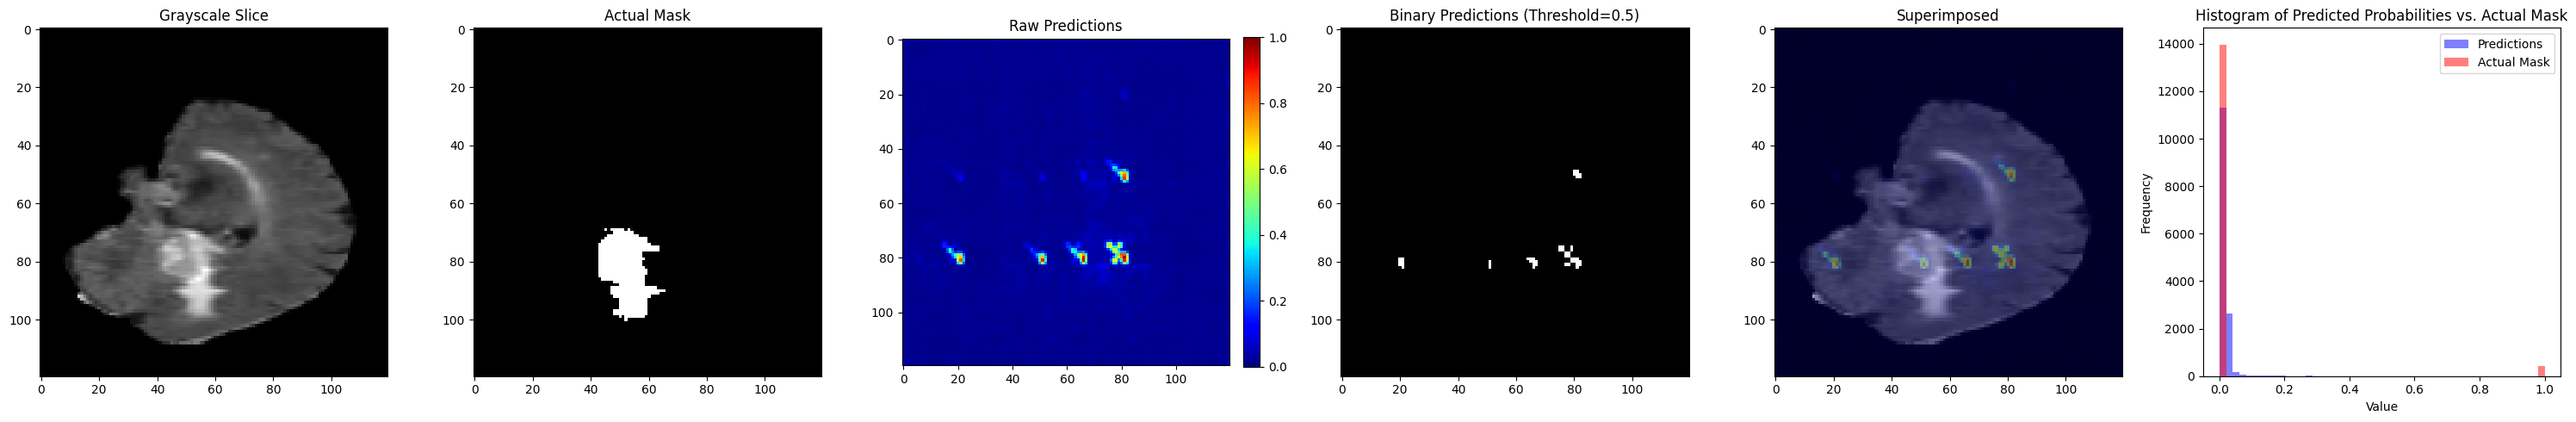

Area of GT: 431.0, Area of Prediction: 48.0
IoU: 0.0063, Tversky Index: 0.0125
- The model might be under-segmenting the region of interest.
['BraTS20_Training_186']


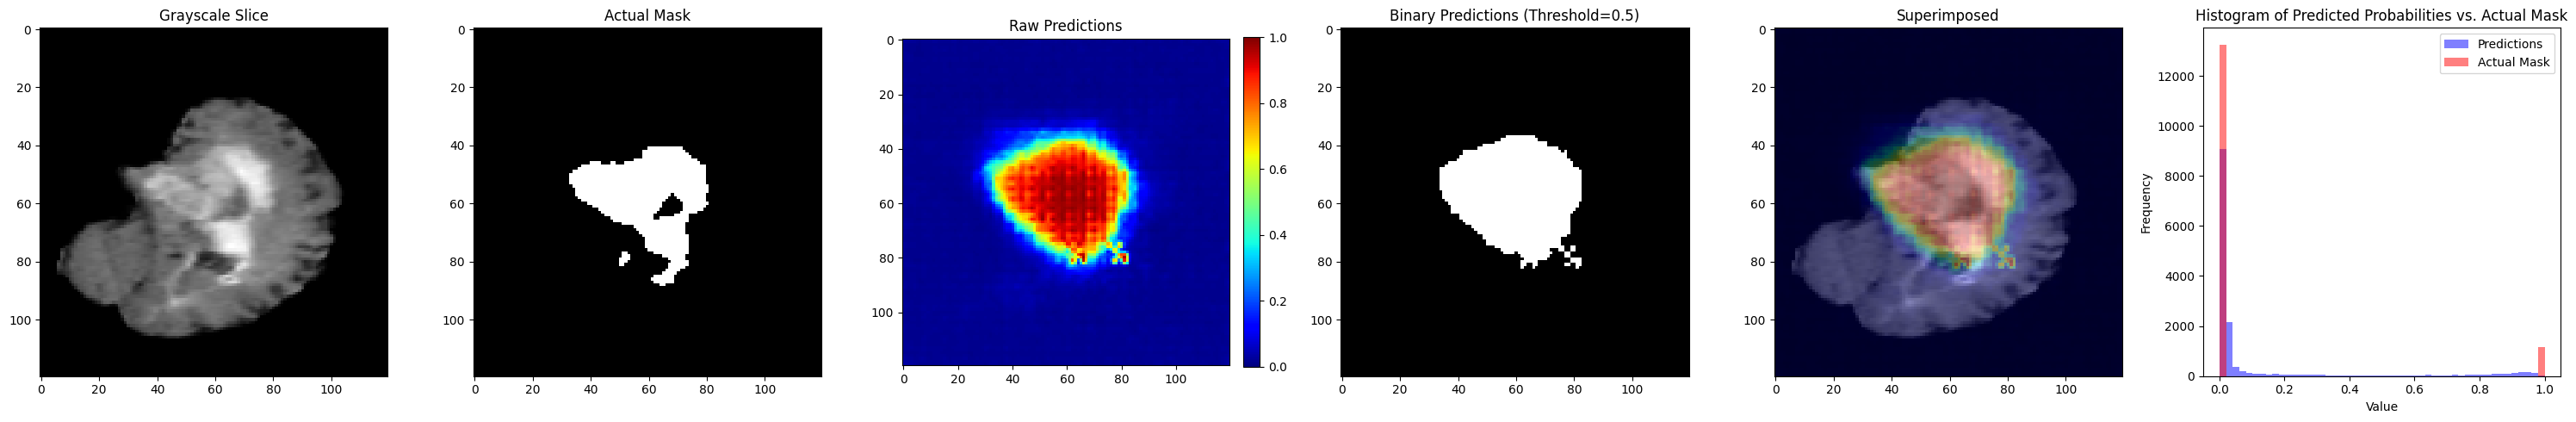

Area of GT: 1146.0, Area of Prediction: 1547.0
IoU: 0.6593, Tversky Index: 0.7947
- The model's segmentation might be slightly shifted or misaligned.
['BraTS20_Training_070']


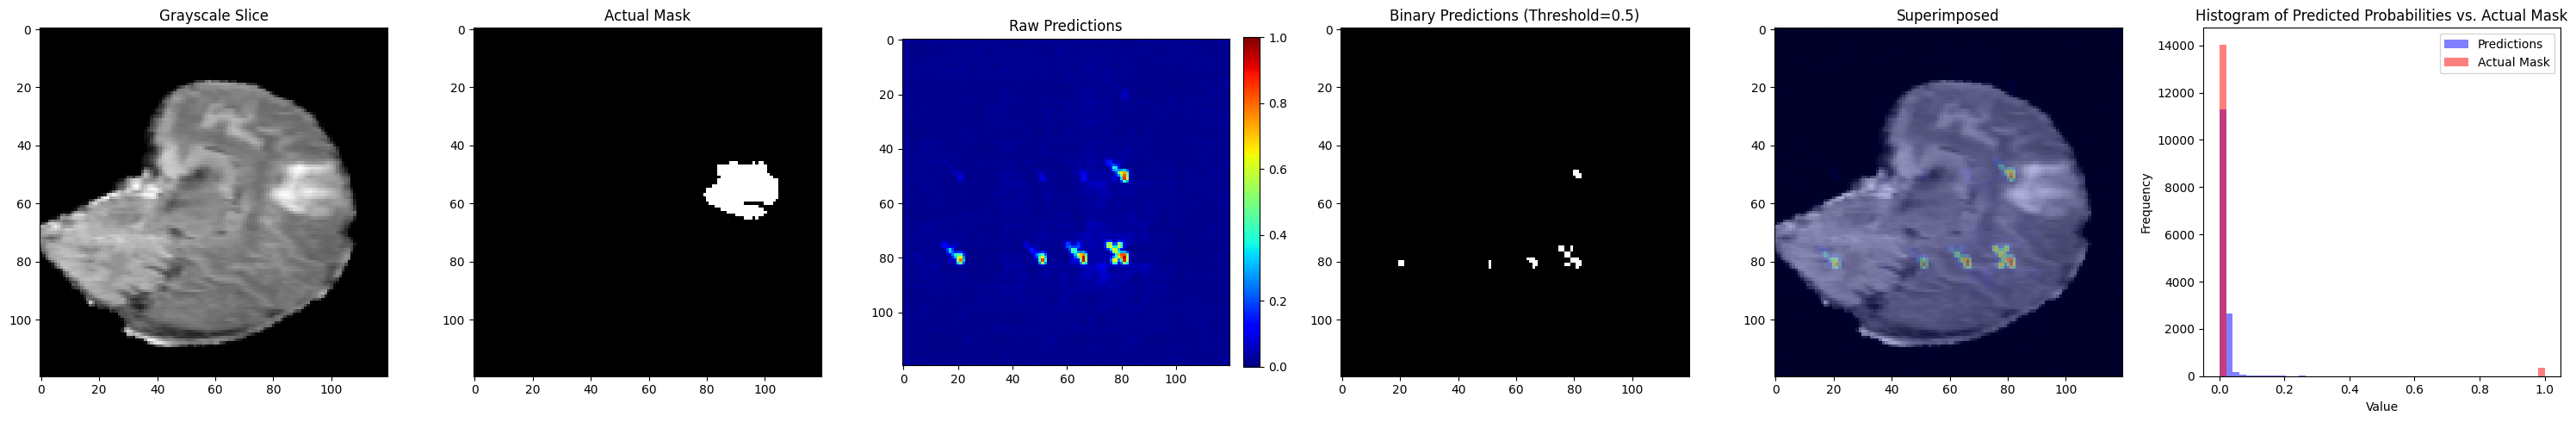

Area of GT: 356.0, Area of Prediction: 45.0
IoU: 0.0000, Tversky Index: 0.0000
- The model might be under-segmenting the region of interest.
['BraTS20_Training_118']


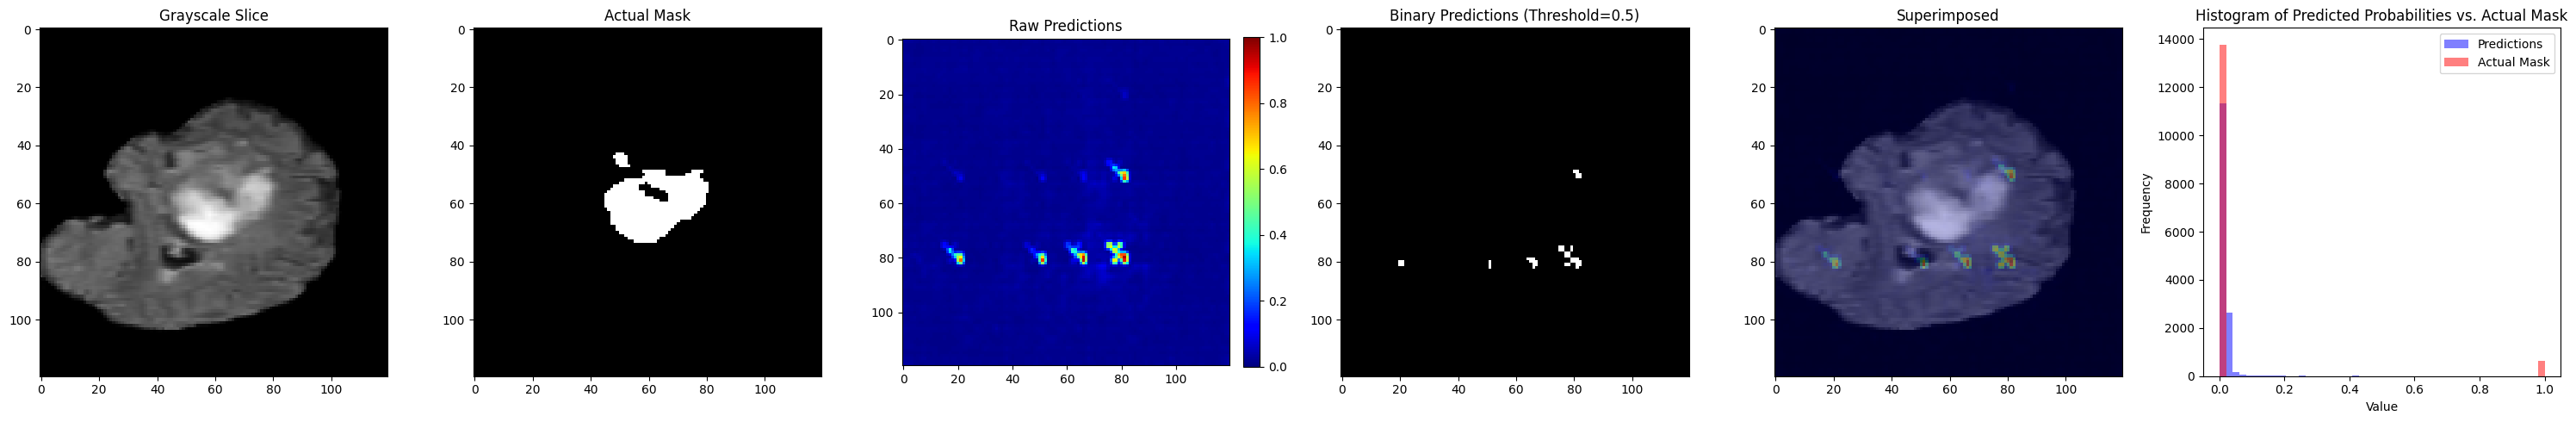

Area of GT: 618.0, Area of Prediction: 44.0
IoU: 0.0000, Tversky Index: 0.0000
- The model might be under-segmenting the region of interest.
['BraTS20_Training_170']


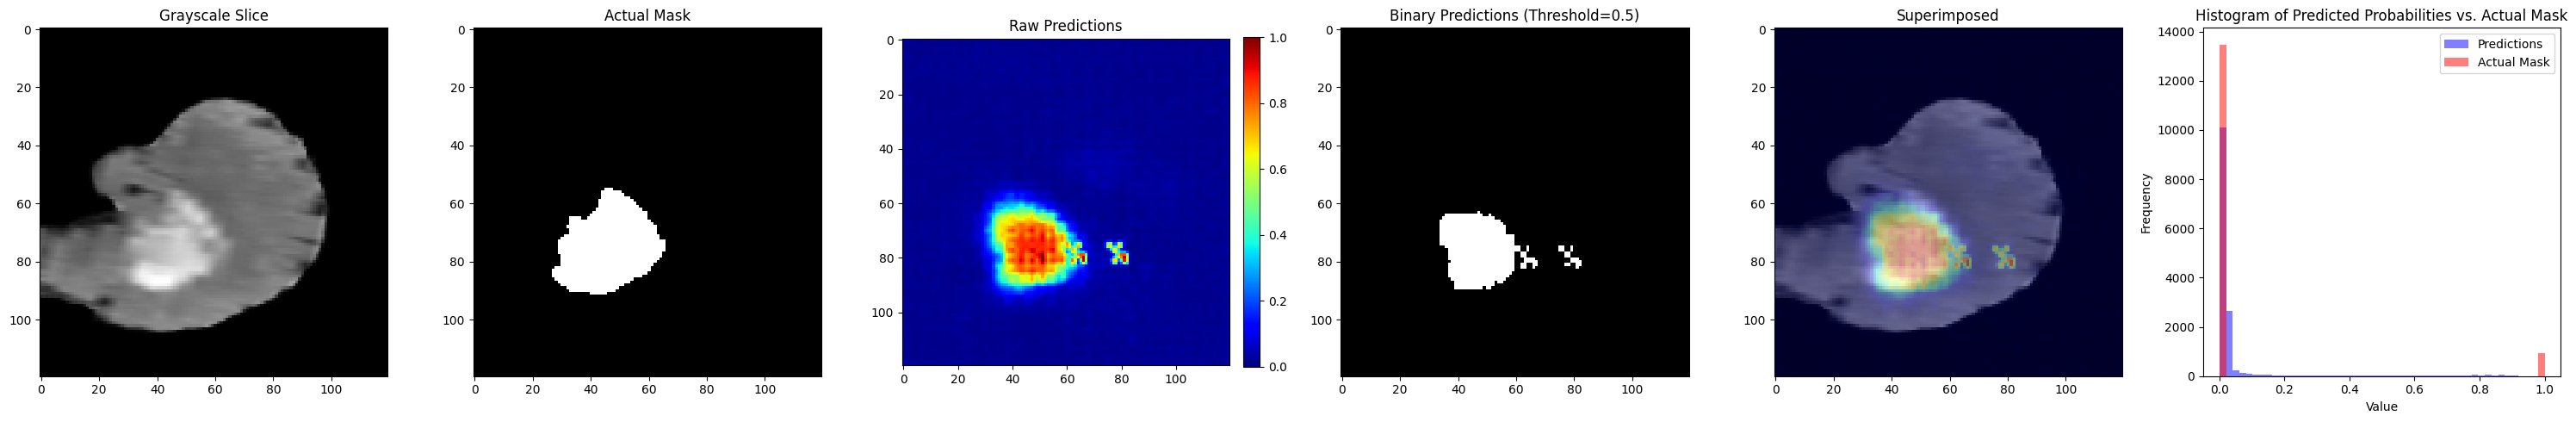

Area of GT: 925.0, Area of Prediction: 608.0
IoU: 0.5723, Tversky Index: 0.7280
- The model's segmentation might be slightly shifted or misaligned.


In [ ]:
# Visualize raw predictions
for sample in train_data_limited:
    print(sample['Id'])
    visualize_raw_predictions(sample, model,threshold=0.5)



['BraTS20_Training_230']


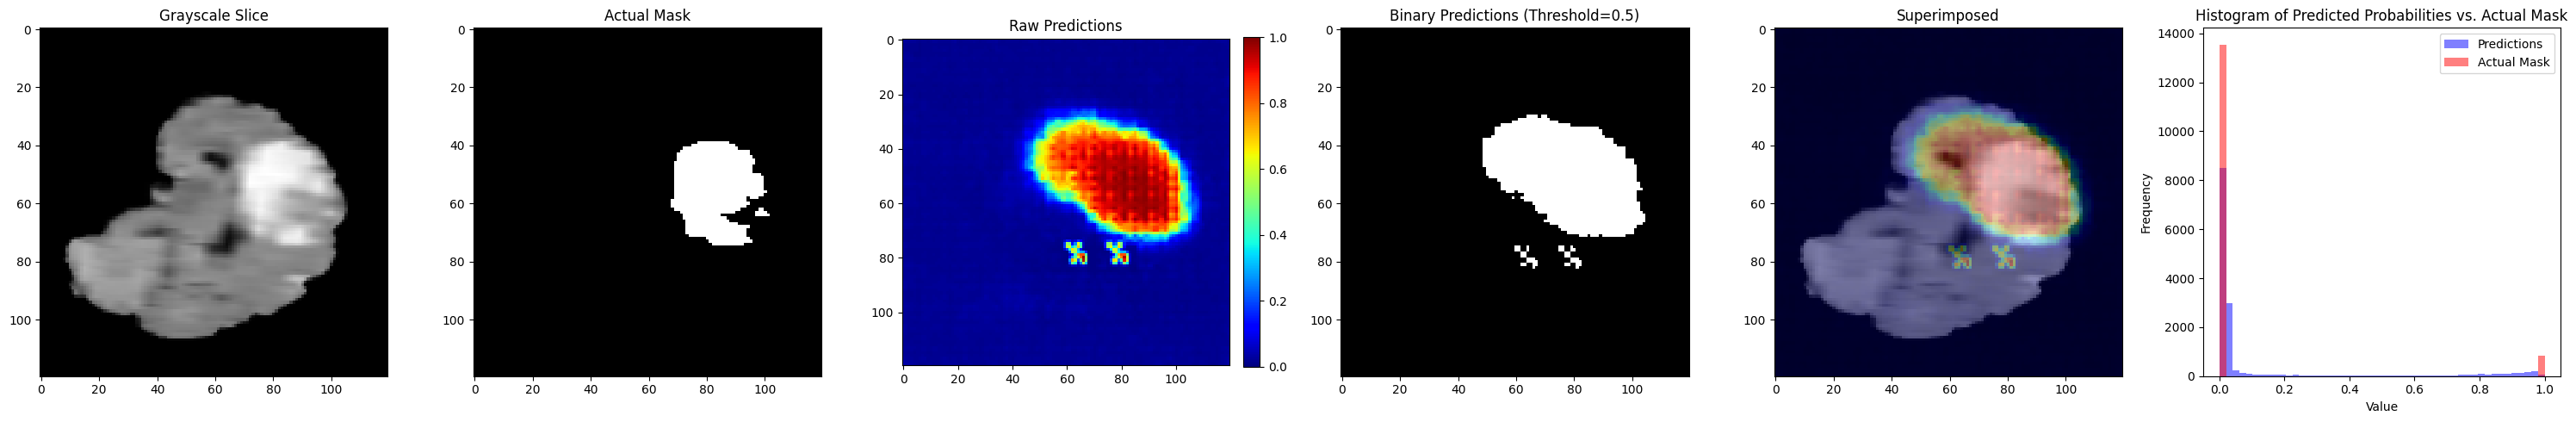

Area of GT: 850.0, Area of Prediction: 1672.0
IoU: 0.4553, Tversky Index: 0.6257
- The model might be over-segmenting the region of interest.
['BraTS20_Training_345']


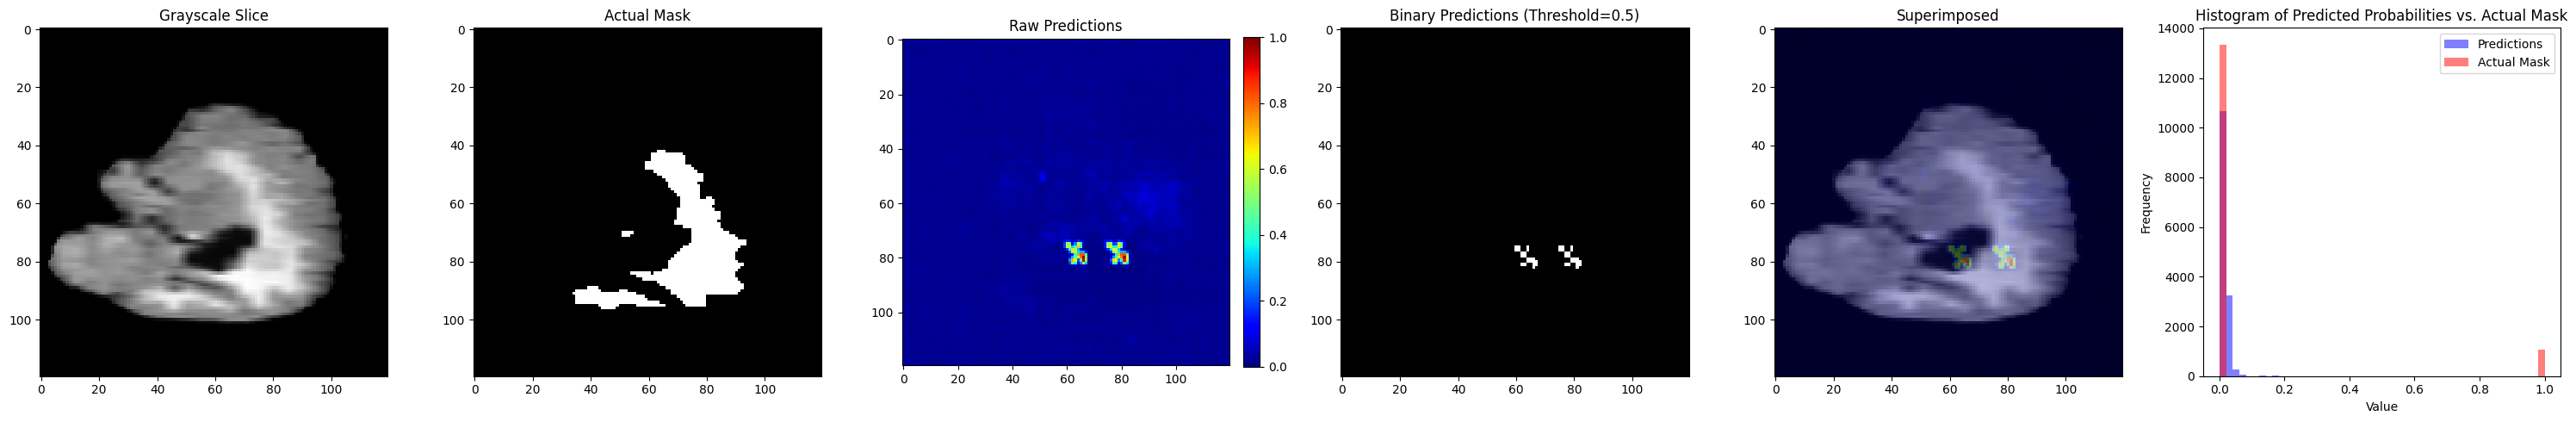

Area of GT: 1048.0, Area of Prediction: 44.0
IoU: 0.0225, Tversky Index: 0.0440
- The model might be under-segmenting the region of interest.
['BraTS20_Training_222']


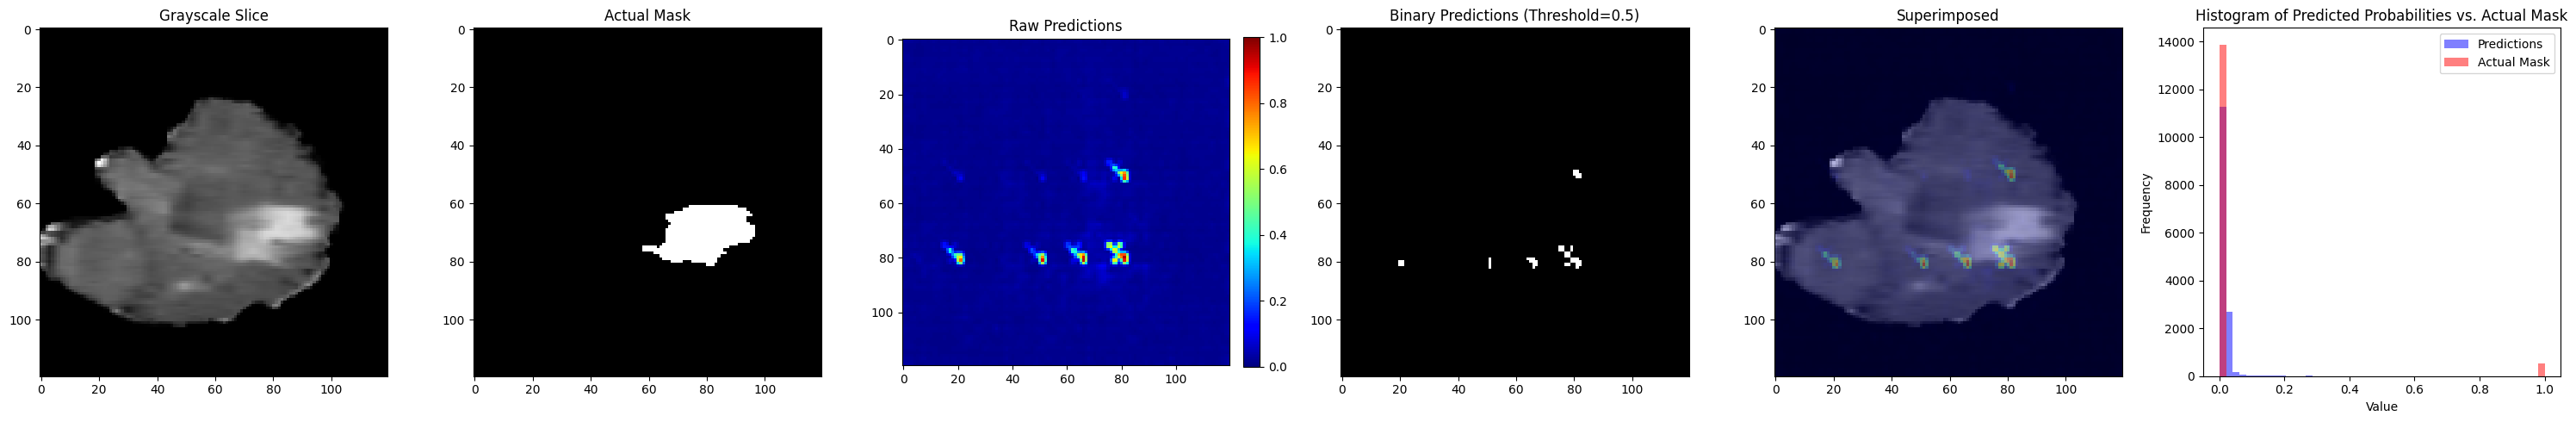

Area of GT: 523.0, Area of Prediction: 46.0
IoU: 0.0383, Tversky Index: 0.0738
- The model might be under-segmenting the region of interest.


In [ ]:
for sample in val_data_limited:
    print(sample['Id'])
    visualize_raw_predictions(sample, model)

In [ ]:
def visualize_prediction(input_image, prediction, ground_truth=None):
    """
    Visualizes the given input image, its predicted mask, and (optionally) the ground truth mask.

    This function takes an input image, its predicted mask, and an optional ground truth mask
    to display the following visualizations side by side:
    1. The original input image.
    2. The input image superimposed with its predicted mask.
    3. The input image superimposed with its ground truth mask (if provided).

    Parameters:
    - input_image (numpy.ndarray): The original 2D image to be visualized.
    - prediction (numpy.ndarray): The predicted mask for the input image.
    - ground_truth (numpy.ndarray, optional): The ground truth mask for the input image. If not provided, this visualization is skipped.

    Returns:
    None. Displays the visualizations using matplotlib.
    """

    plt.figure(figsize=(10, 5))

    # Plot input image
    plt.subplot(1, 3, 1)
    plt.imshow(input_image, cmap='gray')
    plt.title('Input Image')
    plt.axis('off')

    # Superimpose predicted mask on input image
    plt.subplot(1, 3, 2)
    plt.imshow(input_image, cmap='gray')
    plt.imshow(prediction, cmap='jet', alpha=0.5)  # using a transparency of 0.5 for superimposition
    plt.title('Input Image with Predicted Mask')
    plt.axis('off')

    # If ground truth is available, superimpose it on input image
    if ground_truth is not None:
        plt.subplot(1, 3, 3)
        plt.imshow(input_image, cmap='gray')
        plt.imshow(ground_truth, cmap='jet', alpha=0.5)
        plt.title('Input Image with Ground Truth Mask')
        plt.axis('off')

    plt.tight_layout()
    plt.show()



def test_model(model, test_dataloader):
    """
    Tests a given model on a dataloader and visualizes some of its predictions.

    This function evaluates the provided model on a test dataloader. It predicts masks
    for the images in the dataloader and subsequently visualizes a subset of those predictions.
    The function displays the original image, the predicted mask superimposed on the original image,
    and the ground truth mask superimposed on the original image (if available).

    Parameters:
    - model (torch.nn.Module): A trained deep learning model which takes in an image and outputs a mask prediction.
    - test_dataloader (torch.utils.data.DataLoader): A dataloader containing test data samples.

    Returns:
    None. Displays the visualizations of predictions using the `visualize_prediction` function.
    """
    model.eval()

    # Lists to store grayscale slices, their corresponding masks, and their Ids
    grayscale_slices = []
    predicted_masks = []
    patient_ids = []  # List to store the Ids

    with torch.no_grad():
        for sample in test_dataloader:
            grayscale_slice = get_best_slice(sample['image'][0]).float()
            output = model(grayscale_slice.unsqueeze(0).unsqueeze(0))

            mask = torch.sigmoid(output)
            mask = F.interpolate(mask, size=(120, 120), mode='bilinear', align_corners=True)

            # Append grayscale slice, its mask, and its Id to the lists
            grayscale_slices.append(grayscale_slice.squeeze().numpy())
            predicted_masks.append(mask.squeeze())
            patient_ids.append(sample['Id'][0])  # Store the Id

    # Randomly select 5 images/masks and visualize
    for _ in range(5):
        idx = random.randint(0, len(grayscale_slices) - 1)

        print(f"Patient Id: {patient_ids[idx]}")
        visualize_prediction(grayscale_slices[idx], predicted_masks[idx])


Patient Id: BraTS20_Training_119


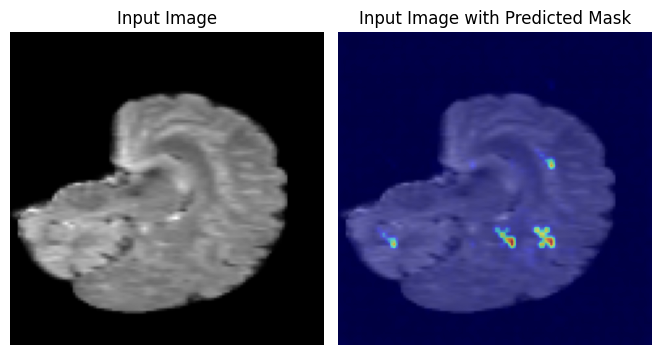

Patient Id: BraTS20_Training_024


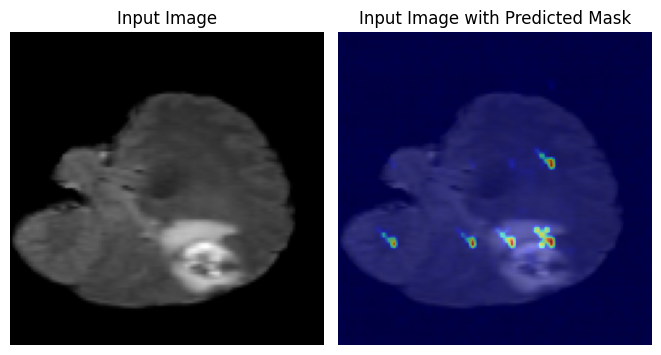

Patient Id: BraTS20_Training_340


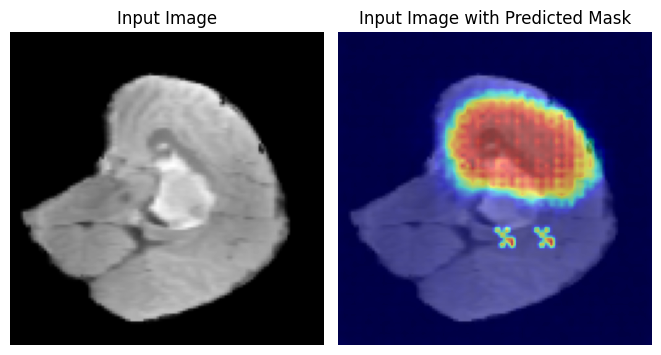

Patient Id: BraTS20_Training_037


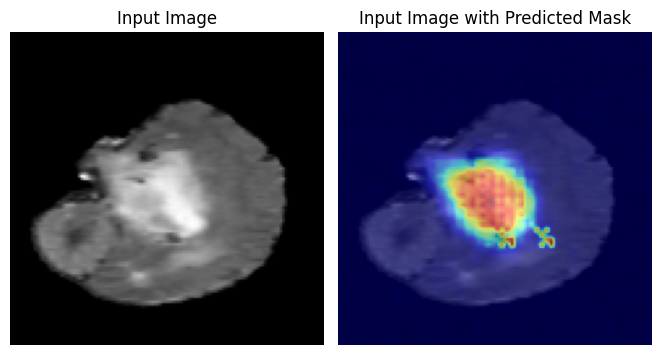

Patient Id: BraTS20_Training_064


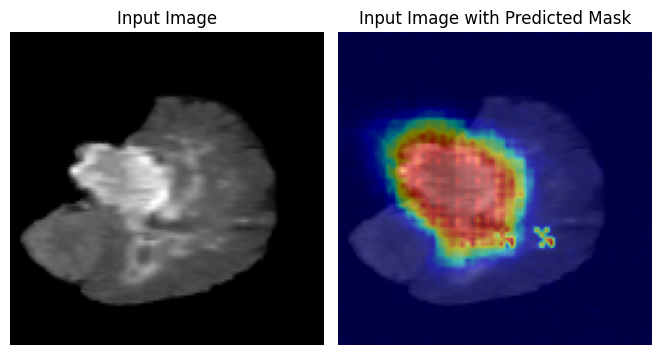

In [ ]:
test_model(model, test_dataloader)

In [ ]:
torch.save(model.state_dict(), config.gcn_model+'/GCN_model_checkpoint.pth')
